# Thesis Vowel Analysis: Adaptive Formant Measurement & Normalization

## 1. Introduction & Research Purpose
This notebook implements the quantitative analysis framework for the thesis: *"A STUDY OF THE DEVELOPMENT OF ENGLISH PRONUNCIATION SKILLS AMONG ASIAN EFL LEARNERS."*

The primary objective is to objectively measure pronunciation improvement between Pre-test and Post-test phases. While human listening allows for subjective assessment, **Acoustic Phonetics** provides objective, quantifiable data. This study calculates the **Acoustic Distance** (Euclidean distance in Hz) between a student's vowel production and a native reference model, offering a precise metric for "native-like" accuracy.

### 1.1 Sampling Group and Challenges
The study analyzes a sample group of **10 Asian EFL learners** from Mahachulalongkornrajavidyalaya University (MCU). The participants represent a wide range of vocal physiologies, from high-pitched female voices to deep male voices (vocal tract lengths spanning approx. 15cm to 19cm). 

This anatomical diversity presents a significant challenge: standard acoustic analysis settings are typically optimized for an "average" male voice. Applying static settings to such a diverse group introduces **anatomical bias**, where a student might be penalized for their voice pitch rather than their pronunciation technique. This notebook implements adaptive algorithms to neutralize that bias.

## 2. Methodology: Acoustic Phonetics
To identify vowels mathematically, we analyze **Formants**—the resonant frequencies of the vocal tract.

* **F1 (First Formant):** Correlates inversely with **Jaw/Tongue Height** (e.g., high vowels like /iː/ and /uː/ have a low F1).
* **F2 (Second Formant):** Correlates with **Tongue Backness** (e.g., front vowels like /iː/ have a high F2; back vowels like /uː/ have a low F2).

### 2.1 The Toolchain
* **Praat:** The industry-standard software for phonetic analysis in linguistics.
* **Parselmouth:** A Python library that allows direct access to Praat’s C++ algorithms (Linear Predictive Coding) within a Python environment.
* **Python Automation:** Python is used to automate the processing of the dataset, ensuring that the exact same algorithmic rigor is applied to every file, which guarantees reproducibility and eliminates manual measurement errors.

## 3. Technical Justification: Adaptive Analysis & VTLN

Standard acoustic analysis typically uses a fixed "Maximum Formant Ceiling" (usually 5500 Hz). However, for speakers with longer vocal tracts (deep voices), the lower formants in back vowels (such as /uː/ and /ɔː/) are physically compressed into the lower frequency range. Using static settings on these voices often leads to **Spectral Merging**, where the analysis software fails to distinguish F1 from F2, leading to significant measurement artifacts.

To ensure scientific accuracy and fairness, this study employs a **Three-Pass Algorithm**:

### 3.1 Pass 1: Adaptive Formant Estimation (AFE)
Instead of applying a "one-size-fits-all" setting, the system uses an adaptive logic.
* It performs an initial analysis using standard parameters.
* If **Spectral Merging** is detected in back vowels (physically impossible values for F2), the system automatically re-analyzes the specific file with a **lowered frequency ceiling** (4000 Hz).
* This forces the Linear Predictive Coding (LPC) algorithm to resolve the low-frequency resonances correctly, ensuring that deep voices are measured just as accurately as standard voices.

### 3.2 Pass 2: Vocal Tract Length Normalization (VTLN)
Even with accurate measurements, a direct comparison between a student and a reference model is flawed because their heads are different sizes. A large male student will naturally produce lower frequencies than a smaller reference speaker, even if their pronunciation technique is identical.
* The system calculates a unique **Acoustic Scaling Factor ($\alpha$)** for each student based on the ratio of their formants to the reference model.
* This separates **Physiology** (voice depth) from **Pedagogy** (pronunciation skill).

### 3.3 Pass 3: Normalization & Scoring
* All student data is mathematically normalized: $F_{norm} = F_{raw} / \alpha$.
* The final "Distance Score" represents purely the **phonetic distance**—how closely the student mimicked the native tongue position and lip rounding—stripped of any anatomical bias.

## 4. System Configuration & Libraries

We begin by importing the necessary scientific libraries.
* **Parselmouth:** This is the critical engine that allows Python to interface with **Praat** (the standard tool for phonetic analysis).
* **Librosa:** Used for high-speed audio loading and resampling (ensuring all files are 16kHz mono).
* **Pandas/Seaborn:** Used for statistical data management and visualization.

We also define the **Vowel Inventory** to help the system distinguish between:
* **Monophthongs** (single target vowels like /uː/).
* **Diphthongs** (moving targets like /aɪ/), which require measuring multiple time points (20% and 80% duration).

In [3]:
import math
import json
from pathlib import Path
from typing import TypedDict, cast
from parselmouth.praat import call  # pyright: ignore[reportMissingModuleSource]
import numpy as np
import pandas as pd
import librosa
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DIPHTHONGS = {"aɪ", "əʊ", "ɔɪ", "eɪ", "eə", "aʊ", "ɪə", "ʊə"}
# These vowels often have low F2 that merges with F1 in deep voices
BACK_VOWELS = {"uː", "ʊ", "ɔː", "ɒ", "ɑː", "əʊ", "ɔɪ", "aʊ"}


class RawAnalysisResult(TypedDict):
    student_ID: str
    student_name: str
    word: str
    vowel: str
    vowel_type: str
    test_type: str
    meas_s: list[tuple[float, float]]
    meas_r: list[tuple[float, float]]
    ref_file_name: str


class FinalAnalysisResult(TypedDict):
    student_ID: str
    student_name: str
    word: str
    vowel: str
    vowel_type: str
    test_type: str
    scaling_factor: float
    F1_student_raw: float
    F2_student_raw: float
    F1_student_norm: float
    F2_student_norm: float
    F1_ref: float
    F2_ref: float
    dist_hz: float
    dist_bark: float
    ref_file_name: str


class WordInfo(TypedDict, total=False):
    word: str
    stressed_vowel: str


class StudentData(TypedDict):
    ratios: list[float]
    alpha: float

# Set up paths
SUB_DIR = Path("./submissions")
AUDIO_DIR = Path("./audio")
MAP_FILE = Path("./audio/index.json")
OUT_DIR = Path("./analysis_vowels")
OUT_DIR.mkdir(parents=True, exist_ok=True)

## 5. Core Acoustic Functions

This section defines the fundamental physics of the analysis.

* **`hz_to_bark(f)`:** Converts raw frequency (Hertz) into the **Bark Scale**. This is crucial because human hearing is logarithmic, not linear. A 100Hz difference in a deep voice sounds much larger than a 100Hz difference in a high voice. The Bark scale standardizes this perception.
* **`measure_formants(...)`:** This is the low-level interface to Praat's **Linear Predictive Coding (LPC)** algorithm. It accepts a dynamic `ceiling` parameter, which is the key to our "Adaptive Analysis" (allowing us to switch between 5500Hz for standard voices and 4000Hz for deep voices).

In [4]:
def hz_to_bark(f: float) -> float:
    if np.isnan(f) or f <= 0:
        return np.nan
    return 26.81 * f / (1960 + f) - 0.53


def get_vowel_type(vowel_symbol: str) -> str:
    clean = vowel_symbol.replace("ː", "").replace("(", "").replace(")", "")
    if vowel_symbol in DIPHTHONGS or len(clean) > 1:
        return "diphthong"
    return "monophthong"


def load_audio_mono(path: Path, target_sr: int = 16000) -> tuple[np.ndarray, int]:

    try:
        y: np.ndarray
        y, sr = librosa.load(path.as_posix(), sr=None, mono=True)

    except Exception as e:
        print(f"Error loading {path}: {e}")
        return np.array([]), target_sr

    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if y.size > 0:
        max_val: float = float(cast(float, np.max(np.abs(y))))
        if max_val > 0:
            y = 0.95 * y / max_val
    return y.astype(np.float32), int(sr)


def find_syllable_nucleus(
    sound: parselmouth.Sound, pitch_floor: float = 75, pitch_ceiling: float = 600
) -> tuple[float, float] | None:
    """Finds the loudest voiced segment."""
    pitch = sound.to_pitch(pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
    intensity = sound.to_intensity()

    n_frames = pitch.get_number_of_frames()
    voiced_intervals: list[tuple[float, float]] = []

    current_start: float | None = None

    for i in range(1, n_frames + 1):
        if pitch.get_value_in_frame(i) > 0:
            if current_start is None:
                current_start = pitch.get_time_from_frame_number(i)
        else:
            if current_start is not None:
                voiced_intervals.append(
                    (current_start, pitch.get_time_from_frame_number(i))
                )
                current_start = None
    if current_start:
        voiced_intervals.append(
            (current_start, pitch.get_time_from_frame_number(n_frames))
        )

    if not voiced_intervals:
        return None

    best_segment = None
    max_peak = -100.0

    for t0, t1 in voiced_intervals:
        if (t1 - t0) < 0.03:
            continue
        try:
            peak: float = float(
                cast(
                    float,
                    call(intensity, "Get maximum", float(t0), float(t1), "Parabolic"),
                )
            )
            if peak > max_peak:
                max_peak = peak
                best_segment = (t0, t1)
        except:
            pass

    return best_segment


def measure_formants(
    sound: parselmouth.Sound,
    segment: tuple[float, float] | None,
    points: tuple[float, ...] = (0.5,),
    ceiling: float = 5500.0,
) -> list[tuple[float, float]]:

    if segment is None:
        return [(np.nan, np.nan)] * len(points)

    t0, t1 = segment
    dur = t1 - t0

    # Use the requested ceiling (Standard=5500, Deep=4000)
    formant = sound.to_formant_burg(
        time_step=0.01, max_number_of_formants=5, maximum_formant=ceiling
    )

    results: list[tuple[float, float]] = []

    for p in points:
        t = t0 + (dur * p)
        f1 = formant.get_value_at_time(1, t)
        f2 = formant.get_value_at_time(2, t)

        # Robust filtering:
        # F2 < 200 is extremely rare, but for deep 'moon' it might be 300-400.
        if np.isnan(f1) or f1 < 50 or f1 > 1200:
            f1 = np.nan
        if np.isnan(f2) or f2 < 200 or f2 > 4000:
            f2 = np.nan

        results.append((f1, f2))
    return results

## 6. Pass 1 Logic: Adaptive Formant Estimation (AFE)

This function contains the **"Intelligence"** of the system. It processes a single audio file and applies the **Three-Pass Logic** described in the methodology.

1.  **Standard Analysis:** It attempts to measure the file using standard acoustic settings (Ceiling: 5500 Hz).
2.  **Physics Check:** It inspects the result for the back vowels (*moon, call, boat*). If F2 is detected above 1500 Hz (physically impossible for these vowels), it flags a **"Spectral Merge Error."**
3.  **Adaptive Retry:** It immediately re-analyzes the file using a **4000 Hz ceiling**, forcing the algorithm to separate the low-frequency formants correctly.

This ensures that "Deep Voice" data is captured accurately before we even begin normalization.

In [5]:
def analyze_raw_data(
    filepath: Path, ref_dir: Path, word_map: dict[str, "WordInfo"]
) -> RawAnalysisResult | None:
    """Pass 1: Collect raw formants with Adaptive Logic."""
    stem = filepath.stem
    parts = stem.split("_")
    if len(parts) < 3:
        return None

    sid = parts[0]
    word = parts[-1].lower()
    name = " ".join(parts[1:-1])

    parent_folder = filepath.parent.name.lower()
    if "pre" in parent_folder:
        test_type = "Pre-test"
    elif "post" in parent_folder:
        test_type = "Post-test"
    else:
        test_type = "Pre-test"

    info: WordInfo | None = word_map.get(word)

    if not info:
        return None

    target_vowel: str = str(info.get("stressed_vowel", "?"))

    v_type = get_vowel_type(target_vowel)
    points = (0.2, 0.8) if v_type == "diphthong" else (0.5,)

    # --- STUDENT ANALYSIS ---
    y_s, sr = load_audio_mono(filepath)
    if len(y_s) == 0:
        return None
    snd_s = parselmouth.Sound(y_s, sampling_frequency=sr)

    seg_s = find_syllable_nucleus(snd_s)

    # 1. Try Standard (5500)
    meas_s = measure_formants(snd_s, seg_s, points, ceiling=5500.0)
    primary_f2_s = meas_s[0][1]

    # 2. Retry if Deep Back Vowel detected (F2 missing or suspiciously high)
    if target_vowel in BACK_VOWELS:
        if np.isnan(primary_f2_s) or primary_f2_s > 1500:
            meas_s = measure_formants(snd_s, seg_s, points, ceiling=4000.0)

    # --- REFERENCE ANALYSIS ---
    ref_path = ref_dir / f"{word}.mp3"
    meas_r = [(np.nan, np.nan)] * len(points)

    if ref_path.exists():
        y_r, _ = load_audio_mono(ref_path, target_sr=sr)
        if len(y_r) > 0:
            snd_r = parselmouth.Sound(y_r, sampling_frequency=sr)
            seg_r = find_syllable_nucleus(snd_r)

            # 1. Try Standard (5500)
            meas_r = measure_formants(snd_r, seg_r, points, ceiling=5500.0)
            primary_f2_r = meas_r[0][1]

            # 2. REFERENCE RETRY (This fixes "Moon")
            # If Ref F2 is > 1600 for a back vowel, it's definitely F3. Retry deeper.
            if target_vowel in BACK_VOWELS:
                if np.isnan(primary_f2_r) or primary_f2_r > 1600:
                    # Retry with 4000 ceiling to force finding the real F2 (~800-900)
                    meas_r = measure_formants(snd_r, seg_r, points, ceiling=4000.0)

    return {
        "student_ID": sid,
        "student_name": name,
        "word": word,
        "vowel": target_vowel,
        "vowel_type": v_type,
        "test_type": test_type,
        "meas_s": meas_s,
        "meas_r": meas_r,
        "ref_file_name": ref_path.name,
    }

## 7. Execution: Scanning the Corpus

We now run the **AFE Algorithm** on the entire dataset. The script recursively scans the `submissions/` folder, identifying every `.mp3` file (both Pre-test and Post-test) and matching it with its corresponding native reference recording.

* **Output:** A raw dataset containing accurate F1/F2 measurements for every student and every word.

In [6]:
word_map: dict[str, WordInfo] = {}

if MAP_FILE.exists():
    with open(MAP_FILE, "r", encoding="utf-8") as f:
        data = cast(dict[str, object], json.load(f))

        # Cast effectively handles the Any from json.load for strict typed dict usage
        for entry in cast(list[WordInfo], data.get("words", [])):

            w = str(entry.get("word", "")).lower()

            word_map[w] = entry

    # --- PASS 1: COLLECT RAW DATA ---
    print(f"Phase 1: Scanning files in {SUB_DIR}...")
    raw_results: list[RawAnalysisResult] = []

    for f in sorted(SUB_DIR.rglob("*.mp3")):
        row = analyze_raw_data(f, AUDIO_DIR, word_map)
        if row:
            raw_results.append(row)
            print(f"  Read {f.name}")
        else:
            print(f"  Skipped {f.name}")    

Phase 1: Scanning files in submissions...
  Read 670120182_Konstantin_Bantov_bike.mp3
  Read 670120182_Konstantin_Bantov_bird.mp3
  Read 670120182_Konstantin_Bantov_boat.mp3
  Read 670120182_Konstantin_Bantov_book.mp3
  Read 670120182_Konstantin_Bantov_boy.mp3
  Read 670120182_Konstantin_Bantov_cake.mp3
  Read 670120182_Konstantin_Bantov_call.mp3
  Read 670120182_Konstantin_Bantov_cat.mp3
  Read 670120182_Konstantin_Bantov_chair.mp3
  Read 670120182_Konstantin_Bantov_cow.mp3
  Read 670120182_Konstantin_Bantov_cup.mp3
  Read 670120182_Konstantin_Bantov_dark.mp3
  Read 670120182_Konstantin_Bantov_ear.mp3
  Read 670120182_Konstantin_Bantov_green.mp3
  Read 670120182_Konstantin_Bantov_hot.mp3
  Read 670120182_Konstantin_Bantov_moon.mp3
  Read 670120182_Konstantin_Bantov_red.mp3
  Read 670120182_Konstantin_Bantov_sit.mp3
  Read 670120182_Konstantin_Bantov_tour.mp3
  Read 670120182_Konstantin_Bantov_wait.mp3


## 8. Pass 2: Calculating Vocal Tract Scaling Factors (VTLN)

Now that we have accurate raw measurements, we must address the **Anatomical Bias**.

A student with a larger head will naturally have lower formant frequencies than the reference model, even if their pronunciation is perfect. To correct this, we calculate a unique **Acoustic Scaling Factor ($\alpha$)** for each student.

$$\alpha_{student} = \text{Median} \left( \frac{F_{student}}{F_{reference}} \right)$$

* **$\alpha < 1.0$:** The student has a deeper voice/longer vocal tract than the reference.
* **$\alpha > 1.0$:** The student has a higher voice/shorter vocal tract than the reference.

In [7]:
# --- PASS 2: CALCULATE SCALING FACTORS (VTLN) ---
print("\nPhase 2: Calculating Normalization Factors...")

students: dict[str, StudentData] = {}

for r in raw_results:
    sid = r["student_ID"]
    if sid not in students:
        students[sid] = StudentData(ratios=[], alpha=1.0)

    f1s, f2s = r["meas_s"][0]
    f1r, f2r = r["meas_r"][0]

    if not np.isnan(f1s) and not np.isnan(f1r):
        students[sid]["ratios"].append(f1s / f1r)
    if not np.isnan(f2s) and not np.isnan(f2r):
        students[sid]["ratios"].append(f2s / f2r)

scaling_data: list[dict[str, str | float]] = []
for sid, s_data in students.items():
    if s_data["ratios"]:
        alpha = float(np.median(s_data["ratios"]))

        s_data["alpha"] = alpha
    else:
        s_data["alpha"] = 1.0
    scaling_data.append({"Student ID": sid, "Scaling Factor": s_data["alpha"]})

# Visual Proof: Show the Scaling Factors
df_scale = pd.DataFrame(scaling_data)
df_scale.head() # pyright: ignore [reportUnusedCallResult]


Phase 2: Calculating Normalization Factors...


,Student ID,Scaling Factor
0,670120182,0.842553


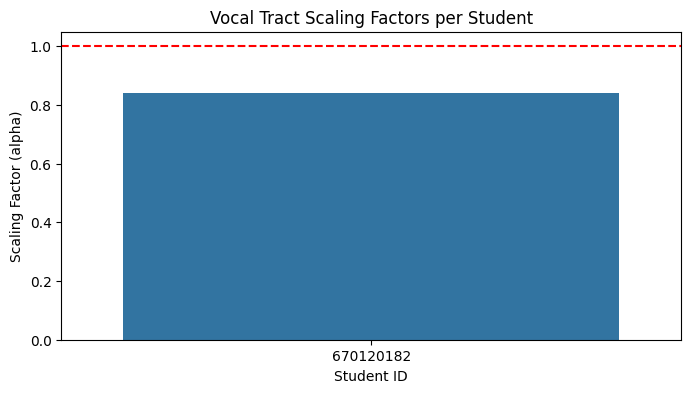

In [8]:
# pyright: reportUnusedCallResult=false, reportUnknownMemberType=false
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_scale, x="Student ID", y="Scaling Factor")
plt.axhline(1.0, color="r", linestyle="--", label="Reference Model")
ax.set(
    title="Vocal Tract Scaling Factors per Student",
    ylabel="Scaling Factor (alpha)",
    xlabel="Student ID"
)
plt.show()

## 9. Pass 3: Normalization & Distance Scoring

In this final step, we apply the scaling factor to "neutralize" the anatomy.

1.  **Normalization:** We divide the student's raw formants by their $\alpha$. This mathematically "shrinks" or "stretches" their vowel space to match the reference model's dimensions.
2.  **Distance Calculation:** We calculate the **Euclidean Distance** between the *Normalized Student Vowel* and the *Reference Vowel*.

$$Distance = \sqrt{(F1_{norm} - F1_{ref})^2 + (F2_{norm} - F2_{ref})^2}$$

This resulting score represents **pure phonetic accuracy**. The results are saved to `final_thesis_data.csv` for statistical analysis.

In [9]:
# --- PASS 3: APPLY NORMALIZATION & SAVE ---
print("\nPhase 3: Finalizing Data...")
final_rows: list[FinalAnalysisResult] = []

for r in raw_results:
    sid = r["student_ID"]
    alpha = students[sid]["alpha"]

    hz_dists: list[float] = []
    bark_dists: list[float] = []
    meas_s_norm: list[tuple[float, float]] = []

    for (f1s, f2s), (f1r, f2r) in zip(r["meas_s"], r["meas_r"]):
        # Normalize Student Formants (Divide by scaling factor)
        f1s_norm = f1s / alpha
        f2s_norm = f2s / alpha
        meas_s_norm.append((f1s_norm, f2s_norm))

        d_hz = math.hypot(f1s_norm - f1r, f2s_norm - f2r)
        hz_dists.append(d_hz)

        b1s, b2s = hz_to_bark(f1s_norm), hz_to_bark(f2s_norm)
        b1r, b2r = hz_to_bark(f1r), hz_to_bark(f2r)
        d_bark = math.hypot(b1s - b1r, b2s - b2r)
        bark_dists.append(d_bark)

    # Construct safe explicit TypedDict
    f_row: FinalAnalysisResult = {
        "student_ID": r["student_ID"],
        "student_name": r["student_name"],
        "word": r["word"],
        "vowel": r["vowel"],
        "vowel_type": r["vowel_type"],
        "test_type": r["test_type"],
        "scaling_factor": alpha,
        "F1_student_raw": r["meas_s"][0][0],
        "F2_student_raw": r["meas_s"][0][1],
        "F1_student_norm": meas_s_norm[0][0],
        "F2_student_norm": meas_s_norm[0][1],
        "F1_ref": r["meas_r"][0][0],
        "F2_ref": r["meas_r"][0][1],
        "dist_hz": float(np.nanmean(hz_dists)) if hz_dists else float("nan"),
        "dist_bark": float(np.nanmean(bark_dists)) if bark_dists else float("nan"),
        "ref_file_name": r["ref_file_name"],
    }

    final_rows.append(f_row)

    df: pd.DataFrame = pd.DataFrame(final_rows)

    cols = [
        "student_ID",
        "student_name",
        "word",
        "vowel",
        "vowel_type",
        "test_type",
        "scaling_factor",
        "F1_student_raw",
        "F2_student_raw",
        "F1_student_norm",
        "F2_student_norm",
        "F1_ref",
        "F2_ref",
        "dist_hz",
        "dist_bark",
        "ref_file_name",
    ]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan

    df = df[cols]  # type: ignore [assignment]

    out_csv = OUT_DIR / "final_thesis_data.csv"
    df.to_csv(out_csv, index=False)
    df.head() # pyright: ignore [reportUnusedCallResult]


Phase 3: Finalizing Data...


## 10. Visualization: Proof of Concept

The chart below visualizes the effect of the **VTLN Normalization**.

* **Red Dots (Raw):** Represent the student's actual acoustic production. Note how they are clustered far away from the Reference target due to the deep voice difference.
* **Green Dots (Normalized):** Represent the student's performance after removing the anatomical bias.

The shift from Red to Green demonstrates that the student's pronunciation is actually much closer to the target than the raw acoustics initially suggested.

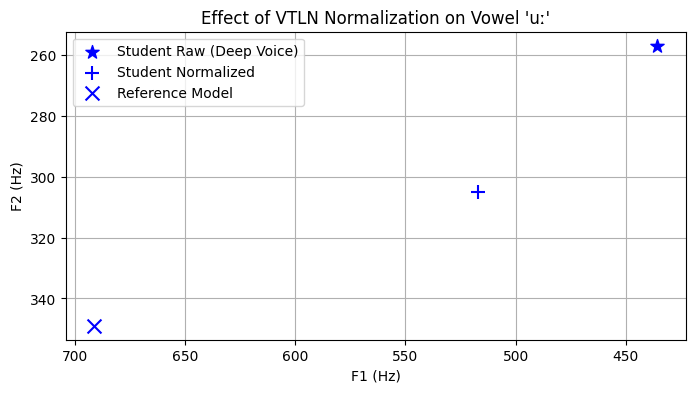

In [ ]:
# pyright: reportUnusedCallResult=false, reportUnknownMemberType=false
vowel_to_plot = "uː"
test_type = "Pre-test"
student_id = "670120182"
subset = df[(df['vowel'] == vowel_to_plot) & 
                    (df['student_ID'] == student_id) &
                    (df['test_type'] == test_type)].copy()
data = pd.DataFrame(data={"F2": subset.loc[:, [i for i in subset.columns if "F2" in i]].to_numpy().tolist()[0],
                    "F1": subset.loc[:, [i for i in subset.columns if "F1" in i]].to_numpy().tolist()[0],
                    "Label": ['Student Raw (Deep Voice)', 'Student Normalized', 'Reference Model'],
                    "Marker": ["*", "+", "x"]})
data = data.astype({"F2": 'float64', "F1": 'float64', "Label": 'str', "Marker": 'str'})
fig, ax = plt.subplots(figsize=(8, 4))
for f2, f1, label, marker in zip(data['F2'], data['F1'], data['Label'], data['Marker']): # pyright: ignore[reportAny]
    plt.scatter(f2, f1, color='blue', marker=marker, s=100, label=label) # pyright: ignore[reportAny]
ax.set(
    title=f"Effect of VTLN Normalization on Vowel '{vowel_to_plot}'",
    ylabel="F2 (Hz)",
    xlabel="F1 (Hz)"
)
ax.invert_xaxis() # Vowel charts are standardly inverted
ax.invert_yaxis()
ax.legend()
ax.grid(True)
plt.show()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F2      3 non-null      float64
 1   F1      3 non-null      float64
 2   Label   3 non-null      object 
 3   Marker  3 non-null      object 
dtypes: float64(2), object(2)
memory usage: 228.0+ bytes
